In [3]:
import scipy.io as sio
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from scipy import signal
%pylab inline
figsize(17, 8)
from scipy.stats import entropy

Populating the interactive namespace from numpy and matplotlib


/Users/chcuneo/ThePost/Personal/Facu/p3venv/lib/python3.5/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['entropy']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [4]:
patients = 10
electrodes = 256
samples = 201

healthy = []
sick = []
for i in range(patients):
    healthy.append(sio.loadmat('data/S{:02d}.mat'.format(i+1))['data'])
    sick.append(sio.loadmat('data/P{:02d}.mat'.format(i+1))['data'])
    print('S{:02d}.mat:'.format(i+1), healthy[-1].shape, 'P{:02d}.mat:'.format(i+1), sick[-1].shape)

S01.mat: (657, 256, 201) P01.mat: (894, 256, 201)
S02.mat: (407, 256, 201) P02.mat: (687, 256, 201)
S03.mat: (809, 256, 201) P03.mat: (700, 256, 201)
S04.mat: (746, 256, 201) P04.mat: (1596, 256, 201)
S05.mat: (697, 256, 201) P05.mat: (857, 256, 201)
S06.mat: (769, 256, 201) P06.mat: (944, 256, 201)
S07.mat: (789, 256, 201) P07.mat: (947, 256, 201)
S08.mat: (800, 256, 201) P08.mat: (901, 256, 201)
S09.mat: (628, 256, 201) P09.mat: (539, 256, 201)
S10.mat: (767, 256, 201) P10.mat: (931, 256, 201)


In [5]:
from collections import defaultdict
band_names = ('delta', 'theta', 'alpha', 'beta', 'gamma')

from math import sqrt
from collections import namedtuple
Stat = namedtuple('Stat', 'total, sum, avg, sd, max, min')
def stat(gen):
    """Returns the namedtuple Stat as below."""
    
    it = iter(gen)

    x0 = next(it)
    mx = mn = s = x0
    s2 = x0*x0
    n = 1

    for x in it:
        mx = max(mx, x)
        mn = min(mn, x)
        s += x
        s2 += x*x
        n += 1

    return Stat(n, s, s/n, sqrt(s2/n - s*s/n/n), mx, mn)

def getBandIntervals(frequencies):
    intervals = []
    intervals.append(('delta', (0, next((i for i,v in enumerate(frequencies) if v >= 4)) - 1)))
    intervals.append(('theta', (intervals[-1][1][1] + 1, next((i for i,v in enumerate(frequencies) if v >= 8)) - 1)))
    intervals.append(('alpha', (intervals[-1][1][1] + 1, next((i for i,v in enumerate(frequencies) if v >= 13)) - 1)))
    intervals.append(('beta', (intervals[-1][1][1] + 1, next((i for i,v in enumerate(frequencies) if v >= 30)) - 1)))
    intervals.append(('gamma', (intervals[-1][1][1] + 1,  len(frequencies) - 1)))
    return intervals

def bandsForPerson(person):
    Y = None
    Z = defaultdict(list)
    cut_index = None
    for epoch in person:
        y, z = signal.welch(np.sum(epoch,axis=0) / len(epoch), fs=250)
        cut_index = cut_index or next((i for i,v in enumerate(y) if v > 50)) # filtro a frecuencias no filtradas en el preprocesamiento
        if Y is None:
            Y = y[:cut_index]
            intervals = getBandIntervals(Y)
        if not np.array_equal(Y, y[:cut_index]):
            print('ATR')
        for label, interval in intervals:
            Z[label].append(np.sum(z[interval[0]:interval[1]+1]))
    
    '''
    Delta < 4 Hz
    4 Hz <= Theta < 8 Hz
    8 Hz <= Alpha < 13 Hz
    13 Hz <= Beta < 30 Hz
    30 Hz <= Gamma < Nyquist
    '''
    return Z

def mutual_information(variables):
    all_vars = np.hstack(variables)
    return (sum([entropy(X) for X in variables]) - entropy(all_vars))

In [6]:
all_people = []
all_people.extend(healthy)
all_people.extend(sick)
gen_values = (sample for person in all_people for epoch in person for electrode in epoch for sample in electrode)
stats = stat(gen_values)
n_bins = int(((stats.max - stats.min) / (3.5*stats.sd*(201**(-1/3))))+1)
bins = np.arange(stats.min, stats.max, (stats.max-stats.min)/n_bins)

## Feature Extraction

In [8]:
columns = []

def spectral(person):
    features = []
    bands = bandsForPerson(person)
    for band_name in band_names:
        if len(columns) < 24:
            columns.append('spectral_{}_avg'.format(band_name))
            columns.append('spectral_{}_sd'.format(band_name))
        stats = stat(bands[band_name])
        features.append(stats.avg)
        features.append(stats.sd)
    
    fullPwrs = np.sum(list(bands.values()), axis=0)
    normalizedBands = {k:v/fullPwrs for k, v in bands.items()}
    for band_name in band_names:
        if len(columns) < 24:
            columns.append('spectral_normalized_{}_avg'.format(band_name))
            columns.append('spectral_normalized_{}_sd'.format(band_name))
        stats = stat(normalizedBands[band_name])
        features.append(stats.avg)
        features.append(stats.sd)
    return features
        
def information(person):
    intra = stat([max([entropy(np.digitize(electrode,bins)) for electrode in epoch]) for epoch in person])
    inter = stat([mutual_information([np.digitize(epoch[31],bins), np.digitize(epoch[145], bins)]) for epoch in person])
    if len(columns) < 24:
        columns.append('info_intra_avg')
        columns.append('info_intra_sd')
        columns.append('info_inter_avg')
        columns.append('info_inter_sd')
    return [intra.avg, intra.sd, inter.avg, inter.sd]

featureFunctions = [spectral, information]
def getFeatures(person):
    info = [spectral(person), information(person)]
    return [feature for features in info for feature in features]

features = [getFeatures(person) for person in tqdm(all_people)]
labels = (['sano'] * len(healthy)) + (['enfermo'] * len(sick))

  0%|          | 0/20 [00:00<?, ?it/s]/Users/chcuneo/ThePost/Personal/Facu/p3venv/lib/python3.5/site-packages/scipy/signal/spectral.py:1637: UserWarning: nperseg = 256 is greater than input length  = 201, using nperseg = 201
  .format(nperseg, input_length))
100%|██████████| 20/20 [05:16<00:00, 16.92s/it]


## Ejercicio 1

In [51]:
import numpy as np
from sklearn import metrics
from sklearn.model_selection import train_test_split

samples_train, samples_test, labels_train, labels_test = train_test_split(features, labels, test_size=.5,
                                                    random_state=0)
 
def plotROC(axis, target, probs, label):
    fpr, tpr, thresholds = metrics.roc_curve(target, probs, pos_label='enfermo')
    if len(fpr) < 2:
        auc = 0.0
    else:
        auc = metrics.auc(fpr, tpr)
    axis.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % auc)
    axis.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    axis.set_xlim([-0.02, 1.02])
    axis.set_ylim([-0.02, 1.02])
    axis.set_xlabel('False Positive Rate')
    axis.set_ylabel('True Positive Rate')
    axis.set_title(label)
    axis.legend(loc="lower right")
    return auc

def plotROCs(data, f_labels):
    ncol = 3
    nrow = int(len(f_labels)/ncol) 
    fig, axs = plt.subplots(nrows=nrow, ncols=ncol)
    ax = axs.flatten()
    auc = 0
    for i, case in enumerate(data):
        auc += plotROC(ax[i], case[0], case[1], f_labels[i])
    print('Average AUC={}'.format(auc/len(data)))

### 1.A

Average AUC=0.49333333333333335


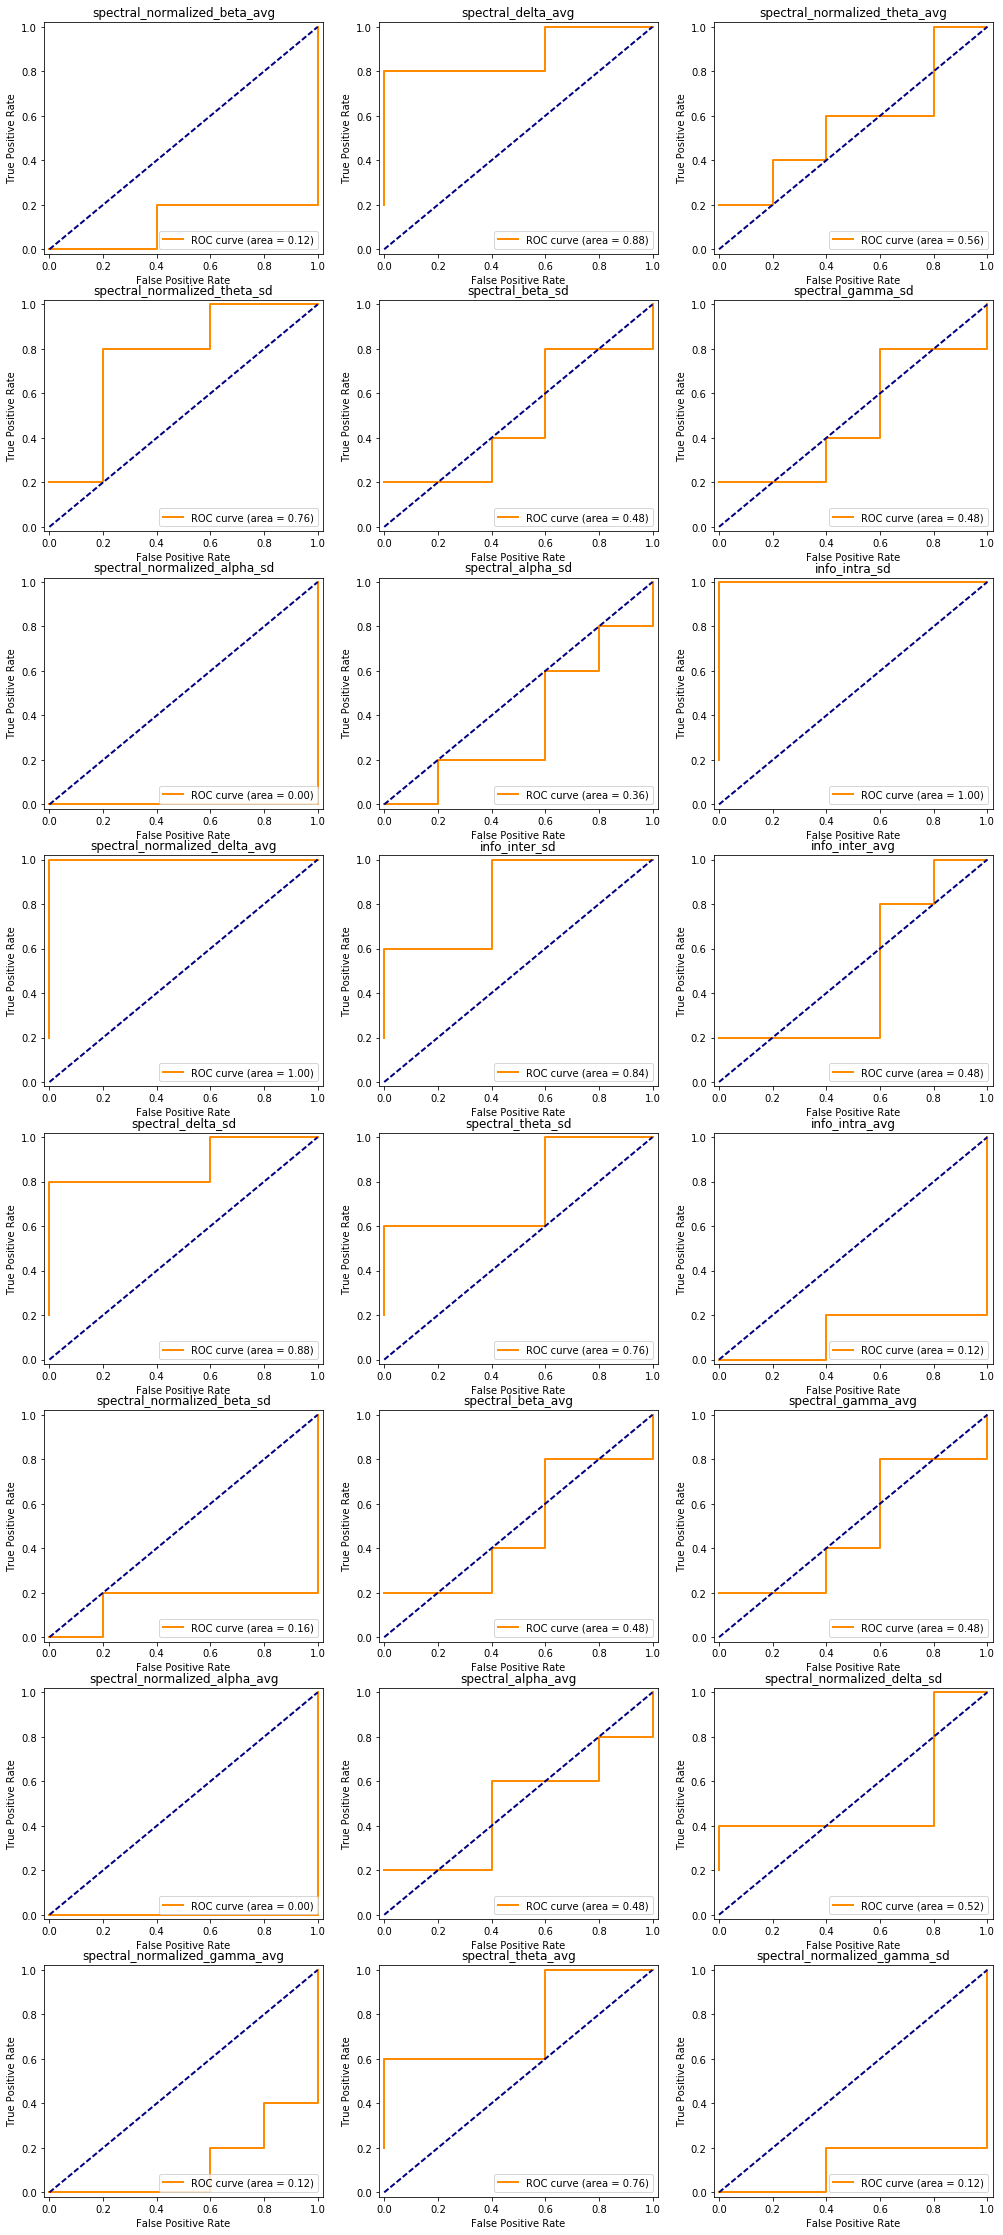

In [52]:
from sklearn.neighbors import KNeighborsClassifier

results_1a = {}    

for i, column in enumerate(columns):
    results_1a[column] = (labels_train, [[s[i]] for s in samples_train])

figsize(17, 40)
plotROCs(results_1a.values(), list(results_1a.keys()))

### 1.B

Average AUC=0.6216666666666666


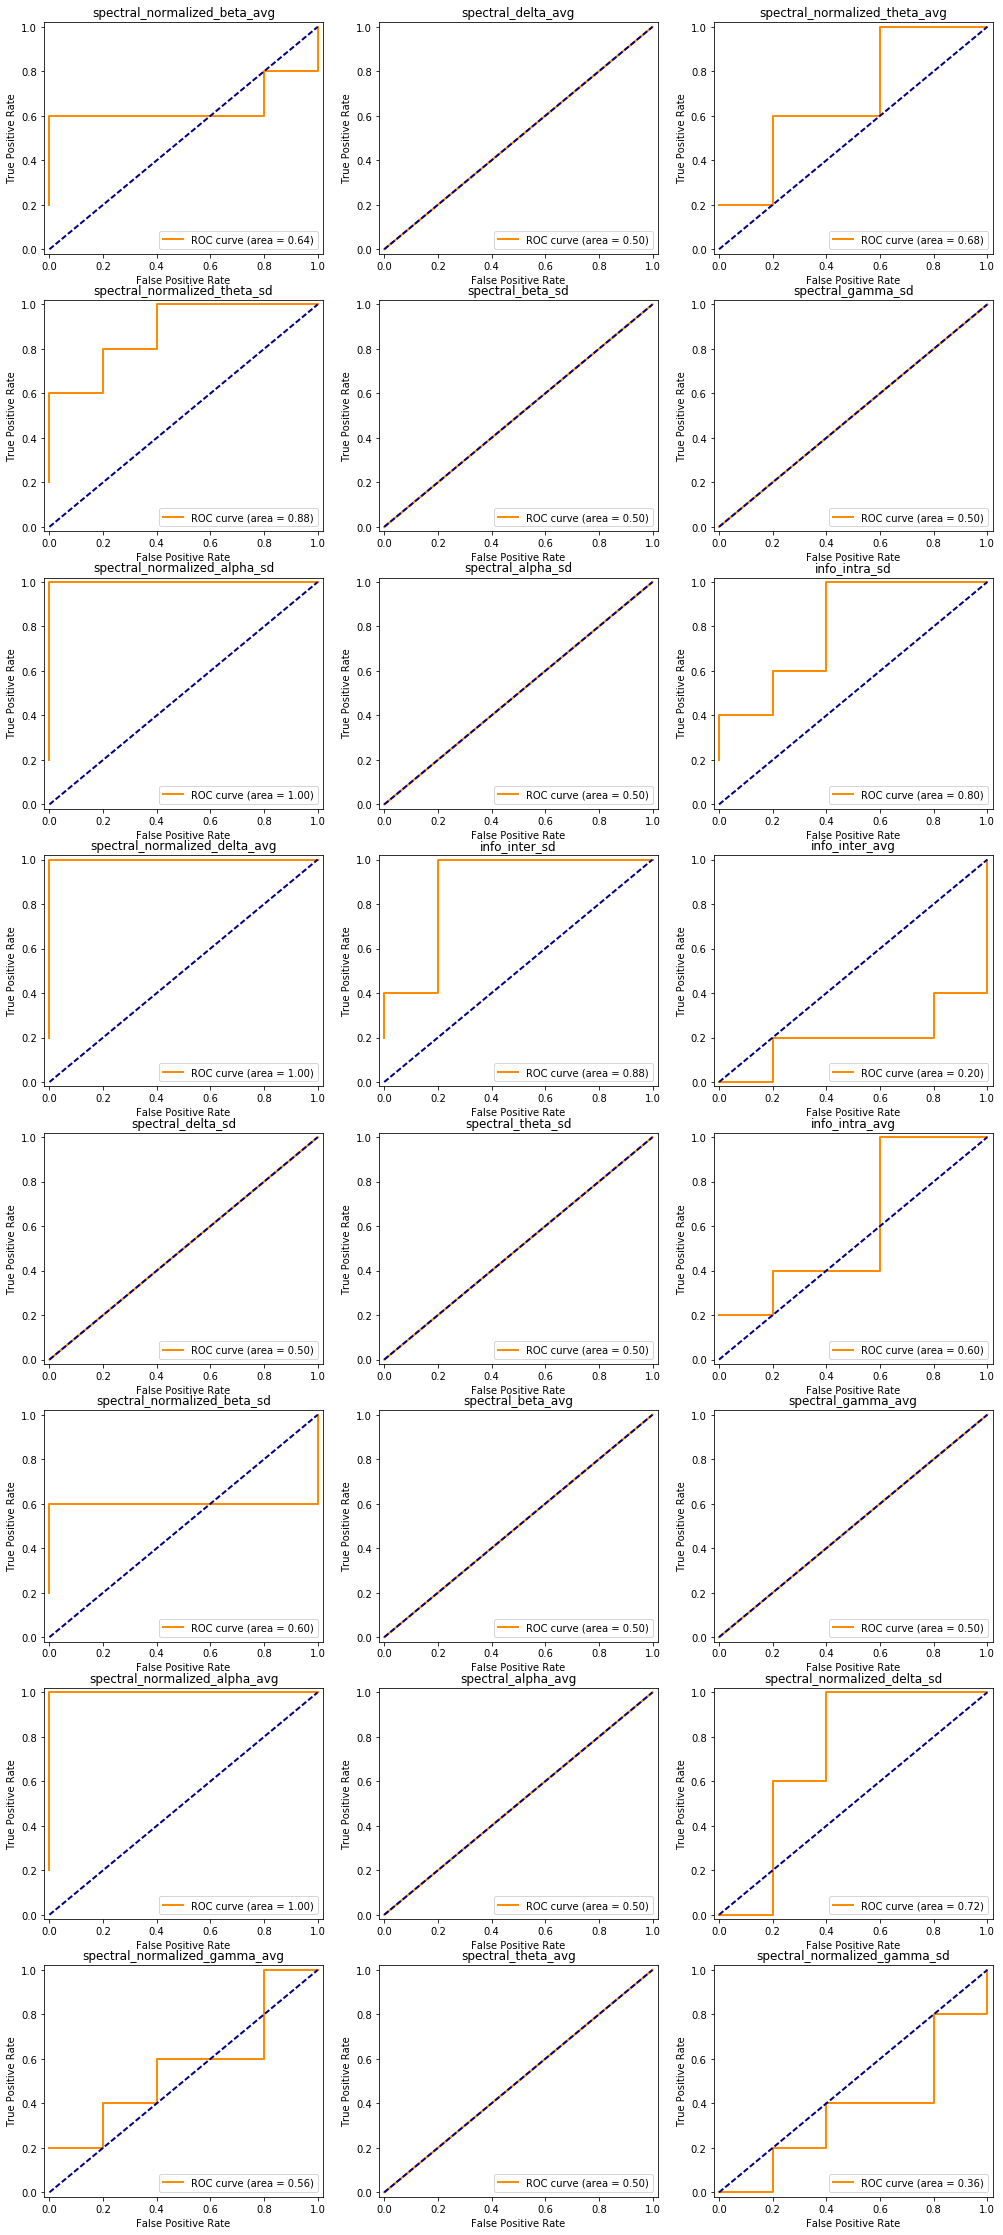

In [53]:
from sklearn.linear_model import LogisticRegression
from sklearn import model_selection

results_1b = {}

def kfcv(classifier, s_train, l_train, s_test):
    kf = model_selection.KFold(n_splits = 3)
    gscv = model_selection.GridSearchCV(estimator=classifier, cv=kf, param_grid={})
    gscv.fit(s_train, l_train)
    probas = gscv.predict_proba(s_test)
    # P[0] es la probabilidad del label 'enfermo' en este caso, me fije a mano
    # print(list(zip(gscv.predict(s_test), probas)))
    return [p[0] for p in probas]

for i, column in enumerate(columns):
    lg = LogisticRegression()
    s_train = [[s[i]] for s in samples_train]
    s_test = [[s[i]] for s in samples_test]
    predicted_probas = kfcv(lg, s_train, labels_train, s_test)
    results_1b[column] = (labels_test, predicted_probas)

figsize(17, 40)
plotROCs(results_1b.values(), list(results_1b.keys()))

Hay casos en los que el area bajo la curva es mejor que en el anterior. Pero en promedio mejoro muchisimo, en el anterior estaba por debajo de 0.5 en este alcanzo 0.62 (siempre promediando entre los auc de todos los features

### 2.A

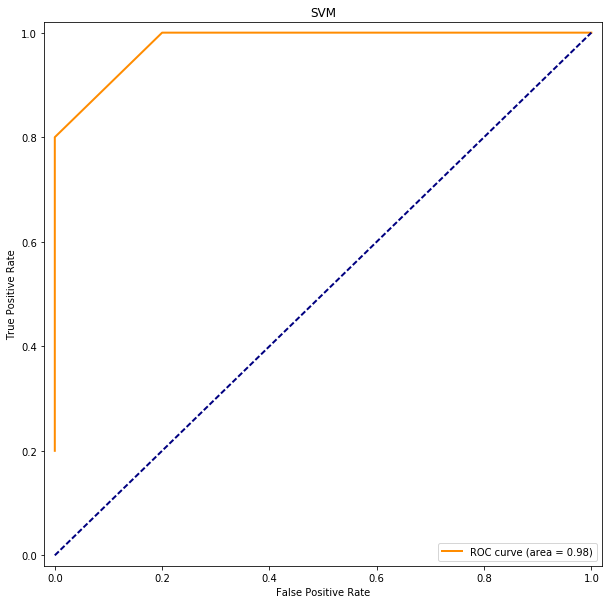

In [48]:
from sklearn.svm import SVC

svc = SVC(probability=True)
svc.fit(samples_train, labels_train)
predicted_labels = svc.predict(samples_test)
predicted_probas = [probas[1] for probas in svc.predict_proba(samples_test)]
# La predicted_probas es la probabiliad del label 'enfermo', me fije a mano
# print(list(zip(predicted_labels, predicted_probas)))
figsize(10, 10)
fig, axs = plt.subplots(nrows=1, ncols=1)
plotROC(axs, labels_test, predicted_probas, 'SVM')

### 2.B

Average AUC=0.94


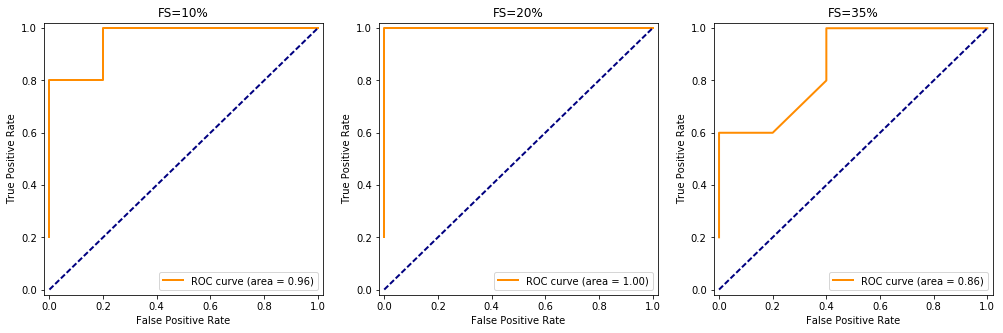

In [54]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectPercentile
from sklearn.svm import SVC

probs = [10, 20, 35]
results_2b = {}
for prob in probs:
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('feature_selection', SelectPercentile(percentile=prob)),
        ('svc', SVC(probability=True)),
    ])
    pipeline.fit(samples_train, labels_train)

    predicted_labels = pipeline.predict(samples_test)
    predicted_probas = [probas[0] for probas in pipeline.predict_proba(samples_test)]
    # La predicted_probas es la probabiliad del label 'enfermo', me fije a mano
    # print(list(zip(predicted_labels, predicted_probas)))
    results_2b['FS={}%'.format(prob)] = (labels_test, predicted_probas)

figsize(17, 5)
plotROCs(results_2b.values(), list(results_2b.keys()))

En este caso se puede ver que 35% no es mejor que 20% ni que el 100% del test anterior. Esto nos muse 